## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# From sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Reading clean data

In [2]:
customers = pd.read_csv('data/customers_prc.csv')
customers.drop(['Unnamed: 0'], axis = 1, inplace = True)

azdias = pd.read_csv('data/azdias_prc.csv')
azdias.drop(['Unnamed: 0'], axis = 1, inplace = True)

### Standardize data

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias)
azdias_scaled = pd.DataFrame(azdias_scaled, columns = azdias.columns)

azdias_scaled.head()

,LNR,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,REGIOTYP_7.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0
0,1.060942,0.758890,0.771572,1.107775,-1.735176,-1.570560,1.172932,1.203659,1.181001,1.147432,...,-0.322464,-0.205798,-0.320952,-0.328443,-0.363296,-0.25723,-0.367167,-0.309555,1.676905,-0.371684
1,1.060961,-0.263506,0.771572,-1.568545,1.184799,1.278729,-0.973028,-0.251101,-1.716472,-1.860914,...,-0.322464,-0.205798,-0.320952,-0.328443,-0.363296,-0.25723,-0.367167,-0.309555,1.676905,-0.371684
2,1.060981,-0.263506,-1.095860,-0.899465,0.454805,0.566407,-1.688349,-0.251101,-0.992104,-1.108827,...,-0.322464,-0.205798,-0.320952,-0.328443,2.752579,-0.25723,-0.367167,-0.309555,-0.596337,-0.371684
3,1.060984,-1.285903,-0.162144,-0.230385,-1.005182,-0.858238,0.457612,0.476279,1.181001,-0.356741,...,-0.322464,-0.205798,3.115734,-0.328443,-0.363296,-0.25723,-0.367167,-0.309555,-0.596337,-0.371684
4,1.061043,0.758890,-1.095860,-0.230385,-0.275189,-0.145915,-0.257708,0.476279,-0.267735,-0.356741,...,-0.322464,-0.205798,-0.320952,-0.328443,-0.363296,-0.25723,2.723555,-0.309555,-0.596337,-0.371684


#### Applying scaling to customers

In [4]:
# First we move the customers-only columns to the end of the DF
cols = list(customers.columns)
avoid = [cols.index('CUSTOMER_GROUP'), cols.index('PRODUCT_GROUP'), cols.index('ONLINE_PURCHASE')]

# New order of columns
new_cols = list(range(min(avoid))) + list(range(max(avoid) + 1, len(cols))) + avoid
customers = customers.iloc[:, new_cols]

customers.head()

,LNR,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CUSTOMER_GROUP,PRODUCT_GROUP,ONLINE_PURCHASE
0,9626,1.0,3.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,MULTI_BUYER,COSMETIC_AND_FOOD,0
1,9628,3.0,6.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,SINGLE_BUYER,FOOD,0
2,143872,3.0,7.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,...,0,0,1,0,0,0,0,MULTI_BUYER,COSMETIC_AND_FOOD,0
3,143873,1.0,7.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,0,1,0,0,0,0,0,MULTI_BUYER,COSMETIC,0
4,143874,3.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,...,0,0,0,0,1,0,0,MULTI_BUYER,FOOD,0


In [5]:
# Then we can apply the scaling to the dataframe
customers_scaled = scaler.transform(customers.iloc[:, :-3])

customers_scaled = pd.DataFrame(customers_scaled, columns = customers.columns[:-3])

# Since we don't need LNR we drop it...
customers_scaled.drop(['LNR'], axis = 1, inplace = True)
azdias_scaled.drop(['LNR'], axis = 1, inplace = True)

customers_scaled.head()

,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,...,REGIOTYP_7.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0
0,-2.308299,-0.629002,0.438695,-1.735176,-1.570560,1.172932,1.203659,1.181001,1.147432,-0.228259,...,-0.322464,4.859136,-0.320952,-0.328443,-0.363296,-0.25723,-0.367167,-0.309555,-0.596337,-0.371684
1,-0.263506,0.771572,1.107775,-1.735176,-1.570560,1.172932,1.203659,1.181001,1.147432,-0.228259,...,-0.322464,-0.205798,3.115734,-0.328443,-0.363296,-0.25723,-0.367167,-0.309555,-0.596337,-0.371684
2,-0.263506,1.238430,1.107775,-1.005182,-0.858238,1.172932,1.203659,1.181001,1.147432,-0.228259,...,3.101125,-0.205798,-0.320952,-0.328443,-0.363296,3.88757,-0.367167,-0.309555,-0.596337,-0.371684
3,-2.308299,1.238430,1.107775,-1.735176,-1.570560,1.172932,1.203659,1.181001,1.147432,-0.228259,...,-0.322464,-0.205798,-0.320952,-0.328443,2.752579,-0.25723,-0.367167,-0.309555,-0.596337,-0.371684
4,-0.263506,-0.629002,0.438695,-0.275189,-0.145915,-0.257708,0.476279,-0.267735,-0.356741,1.637588,...,3.101125,-0.205798,-0.320952,-0.328443,-0.363296,-0.25723,-0.367167,3.230439,-0.596337,-0.371684


In [6]:
# # Sanity checks...
# print( set(azdias_scaled.columns) - set(customers_scaled.columns) )
# print( set(customers_scaled.columns) - set(azdias_scaled.columns) )

# print( sorted(customers_scaled['ANREDE_KZ'].unique()) )
# print( sorted(azdias_scaled['ANREDE_KZ'].unique()) )

# print( sorted(customers_scaled['CJT_KATALOGNUTZER'].unique()) )
# print( sorted(azdias_scaled['CJT_KATALOGNUTZER'].unique()) )


**Saving files...**

In [7]:
customers_scaled.to_csv('data/customers_scaled.csv')

azdias_scaled.to_csv('data/azdias_scaled.csv')

### Principal component analysis

The following analysis aims to provide insights about the key attributes that differentiate the customers from the general population. We will use the PCA() method from the sklearn library.

In [9]:
pca = PCA() 

# Transform features
azdias_pca = pca.fit_transform(azdias_scaled)

In [10]:
# Explained variante ratio of each component
exp_variance = pca.explained_variance_ratio_

cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

Text(28, 0.2555764908425492, 'explained_variance = 50%')

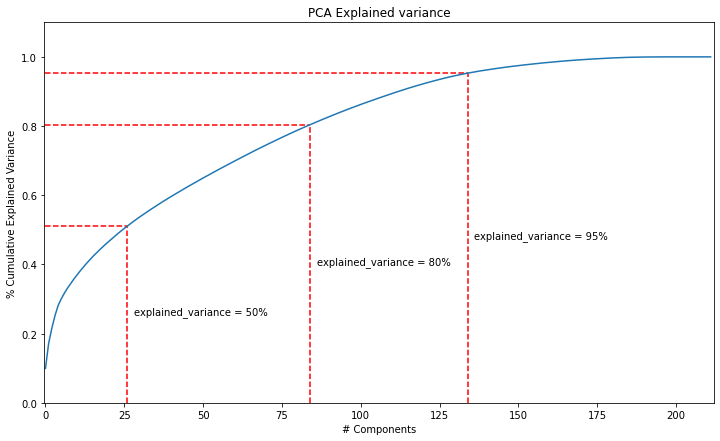

In [11]:
plt.figure(figsize=(12,7))
plt.plot(cumsum_variance)
plt.ylabel('% Cumulative Explained Variance')
plt.xlabel('# Components')
plt.title('PCA Explained variance')
plt.ylim(0, 1.1)
plt.xlim(-0.4, pca.n_components_)

# 95% explained variance
components_95 = (cumsum_variance <= 0.95).sum() + 1
plt.vlines(x = components_95, ymin = 0, ymax = cumsum_variance[components_95], color='red', linestyles='--')
plt.hlines(y=cumsum_variance[components_95], xmin=0, xmax=components_95, color='red', linestyles='--')
plt.text(x = components_95 + 2, y = cumsum_variance[components_95] / 2, s = 'explained_variance = 95%' )


# 80% explained variance
components_80 = (cumsum_variance <= 0.80).sum() + 1
plt.vlines(x = components_80, ymin = 0, ymax = cumsum_variance[components_80], color='red', linestyles='--')
plt.hlines(y=cumsum_variance[components_80], xmin=0, xmax=components_80, color='red', linestyles='--')
plt.text(x = components_80 + 2, y = cumsum_variance[components_80] / 2, s = 'explained_variance = 80%' )

# 50% explained variance
components_50 = (cumsum_variance <= 0.50).sum() + 1
plt.vlines(x = components_50, ymin = 0, ymax = cumsum_variance[components_50], color='red', linestyles='--')
plt.hlines(y=cumsum_variance[components_50], xmin=0, xmax=components_50, color='red', linestyles='--')
plt.text(x = components_50 + 2, y = cumsum_variance[components_50] / 2, s = 'explained_variance = 50%' )

### Component interpretation

In [12]:
def display_component(v, features_list, component_num, n_weights=10):
    global n_components
    
    # get index of component (last row - component_num)
    row_idx = len(v) - component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

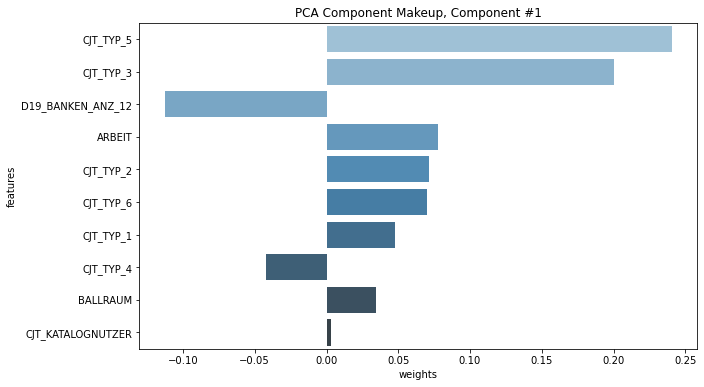

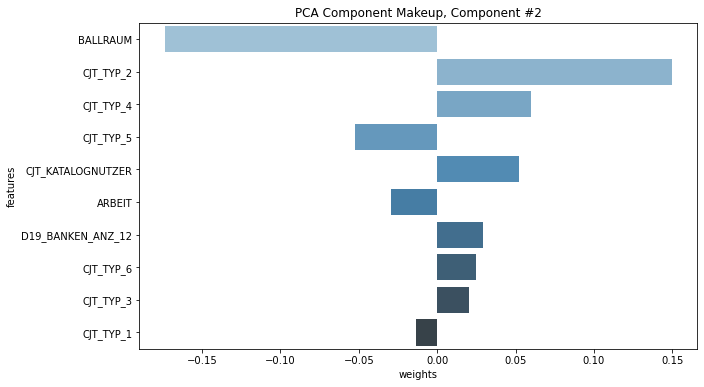

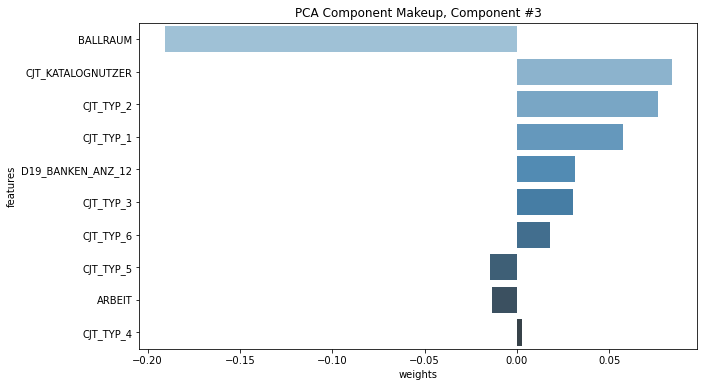

In [13]:
pca = PCA(10) 

# Transform features
azdias_pca = pca.fit_transform(azdias_scaled)

# display makeup of the first three components
display_component(pd.DataFrame( pca.components_ ), azdias_scaled.columns.values, component_num = 1, n_weights = 10)
display_component(pd.DataFrame( pca.components_ ), azdias_scaled.columns.values, component_num = 2, n_weights=10)
display_component(pd.DataFrame( pca.components_ ), azdias_scaled.columns.values, component_num = 3, n_weights=10)

#### Explained variance vs *k*-size clusters.

The aim of the following cell was to show different distributions of customers vs general population with respect to the clustering algorithm. The goal was to find a explained variance parameter for a given *k*, the more difference we see in the bar plots, the better. This is an alternative approach to the elbow method to select *k*, it is also based on a graphical interpretation of the user. 

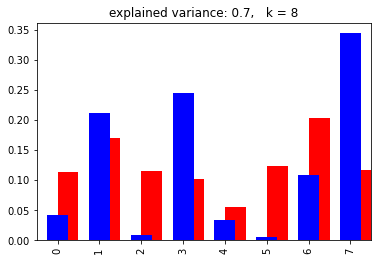

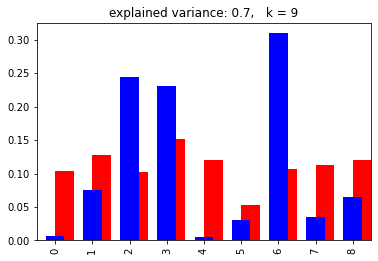

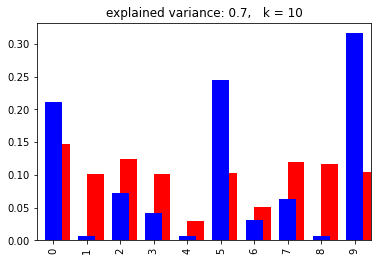

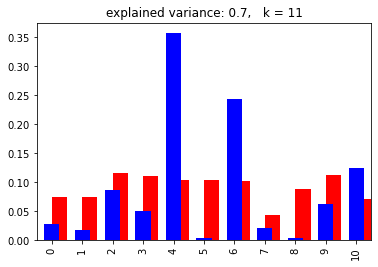

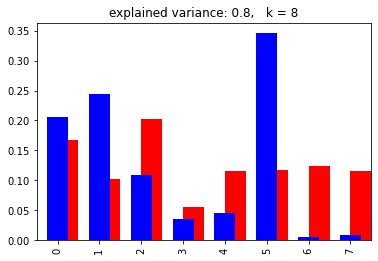

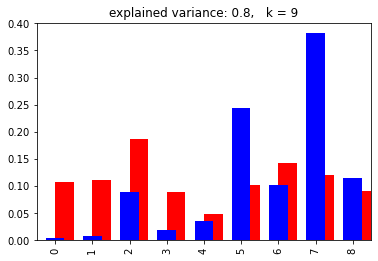

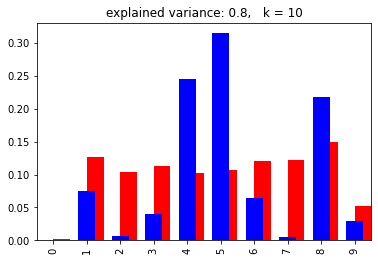

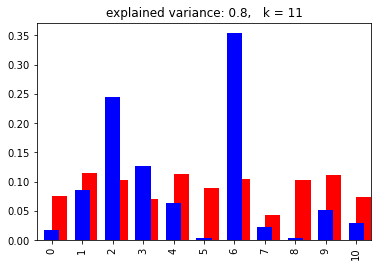

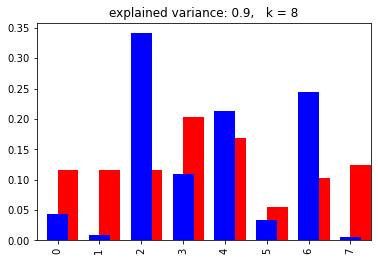

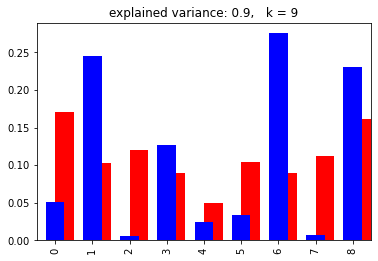

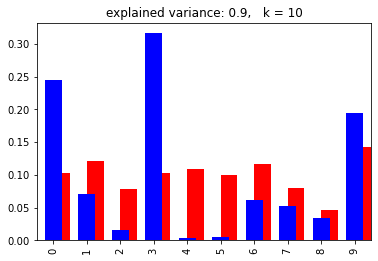

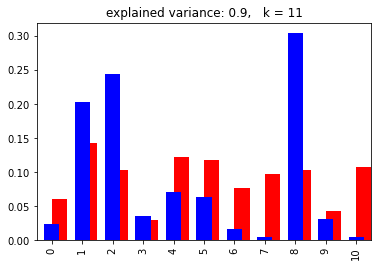

In [19]:
explained_variance = [0.7, 0.8, 0.9]
k_list = [8, 9, 10, 11]

for var in explained_variance:
    pca = PCA(var) 
    
    # Transform features
    azdias_pca = pca.fit_transform(azdias_scaled)
    
    for k in k_list:
        plt.figure()
        kmeans = KMeans(k)
        clusters = kmeans.fit(azdias_pca)
        preds_azdias = clusters.predict(azdias_pca)
        pd.Series(preds_azdias).value_counts(normalize = True).sort_index().plot.bar(color = 'red', width = 0.5, align = 'edge')
        plt.title('explained variance: {},   k = {}'.format(var, k))
        
        
        # Transform customers
        customers_pca = pca.transform(customers_scaled)
        preds_customers = clusters.predict(customers_pca)
        pd.Series(preds_customers).value_counts(normalize = True).sort_index().plot.bar(color = 'blue', width = 0.5, align = 'center')
        plt.show()

### Clustering

We will cluster the general population and then see in which clusters the customers' subset is.

We will use a PCA with a explained_variance of 90%.

In [6]:
pca = PCA(n_components = 0.9) 

# Transform features
azdias_pca = pca.fit_transform(azdias_scaled)

#### Elbow method for *k* selection

The plotting loop performed above is sufficient to chose a value for k, but we still performed the elbow method. 

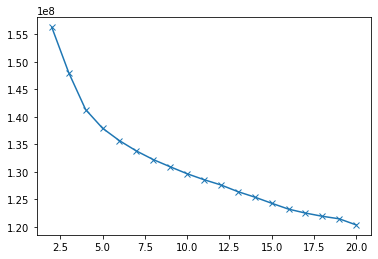

In [21]:
scores = []
min_k = 2
max_k = 20

for k in range(min_k, max_k + 1):
    kmeans = KMeans(k)
    clusters = kmeans.fit(azdias_pca)
    scores.append( clusters.inertia_ )
    
plt.plot(range(2,21), scores, marker = 'x');

<AxesSubplot:>

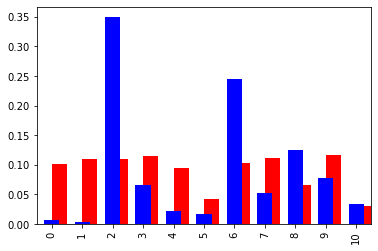

In [7]:
# Selecting k = 11
k = 11

kmeans = KMeans(k)
clust_model = kmeans.fit(azdias_pca)

# Applying reduction to customers
customers_pca = pca.transform(customers_scaled)

# Clusters for customers and azdias
azdias_clusters = clust_model.predict(azdias_pca)
customer_clusters = clust_model.predict(customers_pca)

# Plotting
pd.Series(azdias_clusters).value_counts(normalize = True).sort_index().plot.bar(color = 'red', width = 0.5, align = 'edge')
pd.Series(customer_clusters).value_counts(normalize = True).sort_index().plot.bar(color = 'blue', width = 0.5, align = 'center')

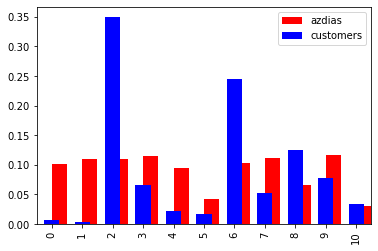

In [8]:
# Plotting
pd.Series(azdias_clusters).value_counts(normalize = True).sort_index().plot.bar(color = 'red', width = 0.5, align = 'edge')
pd.Series(customer_clusters).value_counts(normalize = True).sort_index().plot.bar(color = 'blue', width = 0.5, align = 'center')
plt.legend(['azdias', 'customers']);

## Cluster analysis

Group elements from two or more very different groups of people and compare some essential features, such as sex, or the ones from the PCA interpretation images.

We will compare subjects from cluster **1** (mostly non-customer type persons) with subjects from cluster **4** (customers are overrepresented). 

In [29]:
cluster_under = 0
cluster_over = 2

In [47]:
def compare_distribution(column, norm = True):
    azdias_u = azdias_scaled[azdias_clusters == cluster_under]
    
    customers_o = customers_scaled[customer_clusters == cluster_over]
    
    fig, ax = plt.subplots()
    
    fig.set_size_inches(7, 5)
    
    if len(azdias_u[column].unique()) > 10:
        series_1 = azdias_u[column].value_counts(bins = 5, normalize = norm).sort_index()
        ax.bar(range(1, len(series_1) + 1), series_1.values, width = 0.25, align = 'edge', color = 'red')
        series_4 = customers_o[column].value_counts(bins = 5, normalize = norm).sort_index()
        ax.bar(range(1, len(series_4) + 1), series_4.values, width = -0.25, align = 'edge', color = 'blue')
        ax.legend(['azdias in cluster # {}'.format(cluster_under), 'customers in cluste # {}'.format(cluster_over)])
        ax.set_title('Distribution for {}'.format(column))
        ax.set_ylim([0,1])
                
    else: 
        series_1 = azdias_u[column].value_counts(normalize = norm).sort_index()
        series_4 = customers_o[column].value_counts(normalize = norm).sort_index()
        ax.bar(range(1, len(series_4) + 1), series_4.values, width = -0.25, align = 'edge', color = 'blue')
        ax.bar(range(1, len(series_1) + 1), series_1.values, width = 0.25, align = 'edge', color = 'red')
        ax.legend(['azdias in cluster # {}'.format(cluster_under), 'customers in cluster # {}'.format(cluster_over)])
        ax.set_title('Distribution for {}'.format(column))
        ax.set_ylim([0,1])

### Difference in distribution for customers vs non-customers.

The following barplots show the diffence in distribution between a segment of customers (those in cluster #2) and a segment of the population where there are mostly non-customers (those in cluster #0). 

Ideally, one would have to analyze more than one pair of clusters to reinforce its conclusions, but in this case we would make some parcial conclusions based on a single comparison. 

Observing the difference in distribution should lead to appropiate decisions from the marketing team. We have just selected some attributes considered relevant, but there are more to choose.

#### Age

This feature was introduced in workbook #1. It is a mixed between `ALTERSKATEGORIE_GROB` and `GEBURTSJAHR`:
- 1: Less than 30 years old
- 2: 30 - 45
- 3: 46 - 60
- 4: 60 - 75
- 5: > 75

**Customers tend to be middle-age people, young people do not seem to be potential customers**

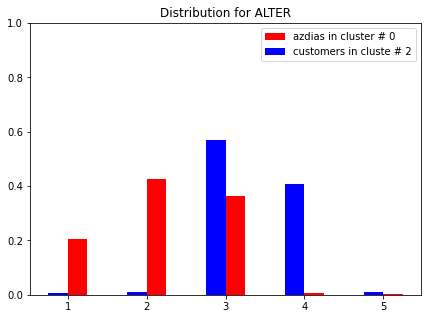

In [48]:
compare_distribution('ALTER')

#### Catalog user typification

(We don't have much information about this attribute)

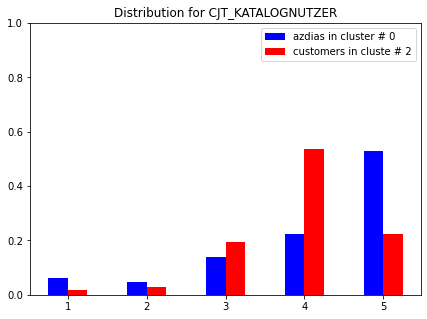

In [32]:
compare_distribution('CJT_KATALOGNUTZER')

#### CJT_TYP_# 

We don't have information about these features in the dictionary files (*probably* refers to a consumer typification), but they have been clearly engineered to differentiate between different type of consumers. **We cannot make a sound conclusion from these attributes becase we don't know its details but they are very useful to detect customers.**

They also appeared in the component makeup above.

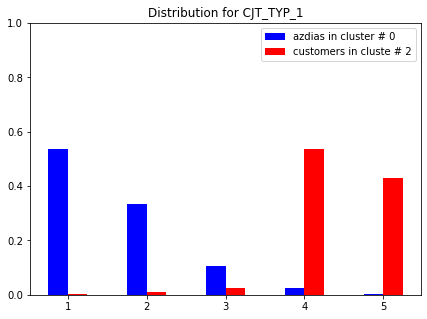

In [34]:
compare_distribution('CJT_TYP_1')

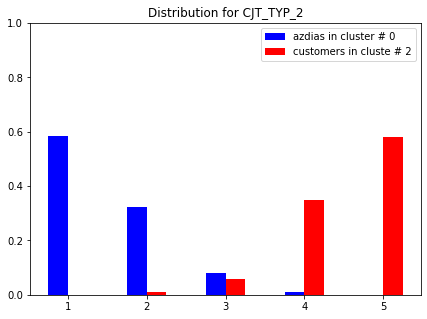

In [35]:
compare_distribution('CJT_TYP_2')

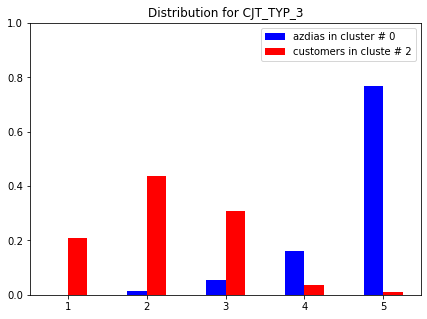

In [36]:
compare_distribution('CJT_TYP_3')

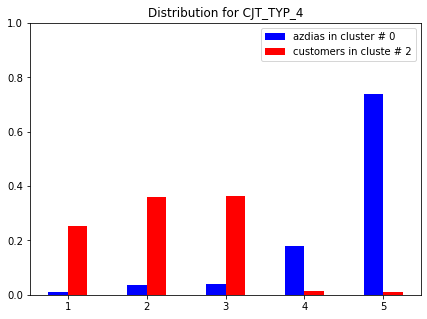

In [37]:
compare_distribution('CJT_TYP_4')

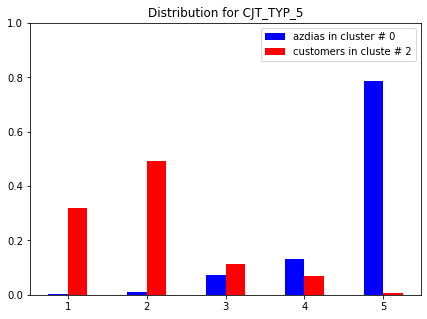

In [38]:
compare_distribution('CJT_TYP_5')

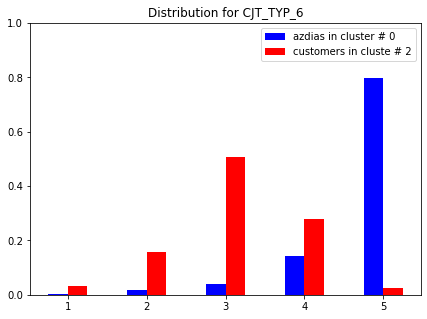

In [39]:
compare_distribution('CJT_TYP_6')

#### Purchasing power

- 1: Very high
- 2: high
- 3: average
- 4: low

**There is a small tendency for customers to have from average to low purchasing power**

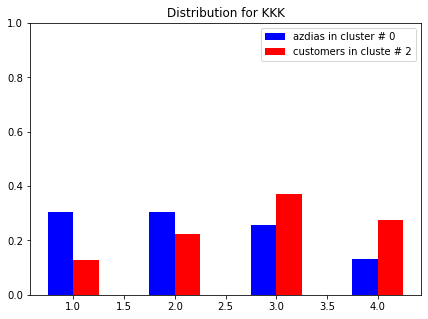

In [40]:
compare_distribution('KKK')

#### Estimated household net income

- 1: Highest income
- 2: Very high income
- 3: High income 
- 4: Average income
- 5: lower income
- 6: very low income

**This graph reinforce the previous plot, customers tend to be average and lower income persons**

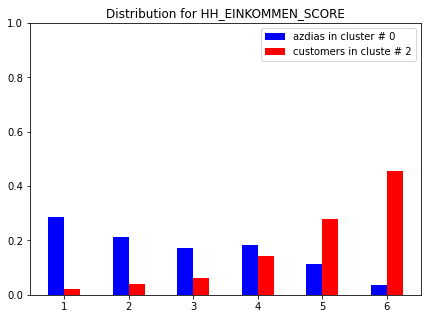

In [41]:
compare_distribution( 'HH_EINKOMMEN_SCORE' )  #** Very important ** We noticed since workbook 1

**LP_STATUS_GROB** 

Social status rough.

Dummy variable with value = 1.0 - "low-income earners"

**Once again, based on the pair of selected clusters we observe that customers tend to be low-income earners**

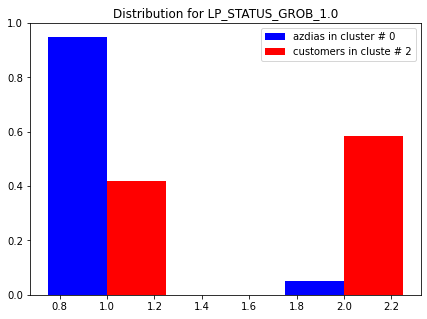

In [42]:
compare_distribution( 'LP_STATUS_GROB_1.0' )

#### Finance typification

Best describing financial type of person.
- 1: low financial interest
- 2: money saver
- 3: main focus is the own house
- 4: be prepared
- 5: investor
- 6: unremarkable

**Customers have low financial interest, but they are not money savers**

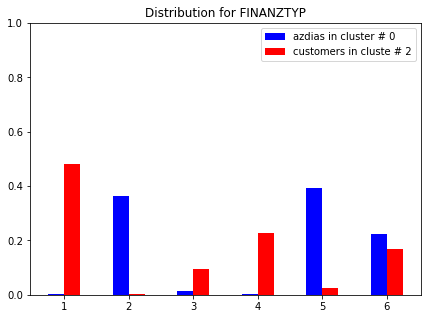

In [43]:
compare_distribution('FINANZTYP')

### Conclusion



Customers of the mail order company are somewhat identified from the general population, our analysis shows that they tend to be middle age people with average to low incomes but with a tendency to buy, because they are not money savers.

It would interesting to know the meaning of the CJT_TYP_# attributes, because they surely have more important information.